# Prior plots for Gaussian Mixture Model

Create a multivariate Gaussian Mixture Model prior and return plots of the function.

In [1]:
%matplotlib inline

import numpy as np
import subprocess as sp
import os

# matplotlib
import matplotlib as mpl
from matplotlib import pyplot as pl

# scipy
from scipy import stats

from lalapps.pulsarpputils import *
from lalapps.pulsarhtmlutils import exp_str

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 15 }

mpl.rcParams.update(mplparams)

In [12]:
# the lalapps_pulsar_parameter_estimation_nested code requires are par file to run, so create this

parfile = 'priorfunc.par'
fp = open(parfile, 'w')
par = """PSRJ J0000+0000
RAJ 00:00:00.0
DECJ 00:00:00.0
F0 100.0
PEPOCH 50000
"""
fp.write(par)
fp.close()

# set up location of lalapps_pulsar_parameter_estimation_nested code
virenv = 'lalapps_knope_O2' # name of your virtual environment
execpath = os.path.join(os.environ['WORKON_HOME'], virenv)
execpath = os.path.join(execpath, 'bin')

ppenexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested')

# number of samples from prior
N = 10000

# code call
codecall = "{} --par-file {} --prior-file {} --sampleprior {} --outfile samples.hdf --Nlive {} --fake-data H1 --Nmcmcinitial 0"

# remove samples file if it already exists 
if os.path.isfile('samples.hdf'):
    os.remove('samples.hdf')

Create a 2D Gaussian Mixture Model with two modes. This requires two covariance matrices and two sets of parameter means.

In [45]:
# use H0 and COSIOTA as the two parameters
nmodes = 2
npars = 2

#sigmas = np.array([[1e-24, 0.05], [2e-24, 0.1]]) # standard devaitions of two parameters for each mode
sigmas = np.array([[1.0, 0.05], [2., 0.1]])
mus = np.array([[4.0, -0.2], [20., 0.4]])    # means of the two parameters for each mode

cors = np.array([[[1., 0.9],[0.9, 1.]],[[1., -0.4],[-0.4, 1.]]]) # correlation matrices for each mode

covs = np.zeros(cors.shape) # create covariance matrices
for i in range(nmodes):
    R = np.identity(2)*sigmas[i]
    covs[i] = np.dot(R, np.dot(cors[i], R))
    
# set weights
weights = [1., 2.]

# output prior file
priorfile = 'priorfunc.prior'
fp = open(priorfile, 'w')
#prior = "H0:COSIOTA gmm {} {} {} {}"
prior = "PHI0:COSIOTA gmm {} {} {} {}"

mustr = '['
weightstr = '['
covstr = '['
for i in range(nmodes):
    mustr += '['
    covstr += '['
    for j in range(npars):
        mustr += '%e' % mus[i][j]
        covstr += '['
        for k in range(npars):
            covstr += '%e' % covs[i][j][k]
            if k < npars-1:
                covstr += ','
        covstr += ']'
        if j < npars-1:
            covstr += ','
            mustr += ','
    weightstr += '%e' % weights[i]
    mustr += ']'
    covstr += ']'
    if i < nmodes-1:
        mustr += ','
        covstr += ','
        weightstr += ','
mustr += ']'
covstr += ']'
weightstr += ']'

fp.write(prior.format(nmodes, mustr, covstr, weightstr))
fp.close()

In [46]:
# run code
p = sp.Popen(codecall.format(ppenexec, parfile, priorfile, N, N), stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# read in the samples
samples, evsig, evnoise = pulsar_nest_to_posterior('samples.hdf', nestedsamples=True)

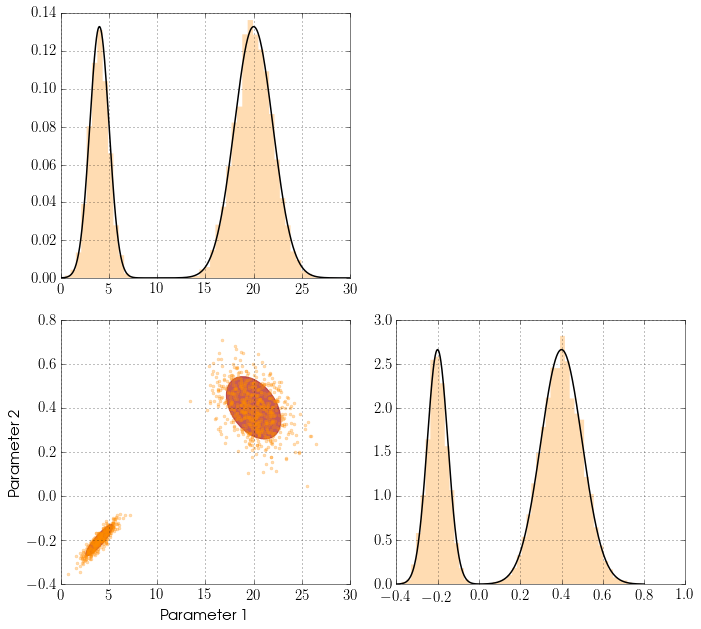

In [52]:
fig, axs = pl.subplots(2,2, figsize=(10,9))

#axs[0][0].hist(samples['H0'].samples, bins=50, normed=True, histtype='stepfilled', alpha=0.3, facecolor='orange', edgecolor='none')
axs[0][0].hist(samples['PHI0'].samples, bins=50, normed=True, histtype='stepfilled', alpha=0.3, facecolor='darkorange', edgecolor='none')
axs[1][1].hist(samples['COSIOTA'].samples, bins=50, normed=True, histtype='stepfilled', alpha=0.3, facecolor='darkorange', edgecolor='none')
#axs[1][0].plot(samples['H0'].samples[::10], samples['COSIOTA'].samples[::10], '.')
axs[1][0].plot(samples['PHI0'].samples[::10], samples['COSIOTA'].samples[::10], '.', alpha=0.3, color='darkorange')
axs[0][1].axis('off')

# overplot expected GMM pdfs
def gmmpdf(x, means, sigmas, weights, pidx):
    gp = np.zeros(len(x))
    for i in range(len(means)):
        mu = means[i][pidx]
        sig = sigmas[i][pidx]
        weight = weights[i]
        rv = stats.norm(loc=mu, scale=sig) # create mode
        gp += weight*rv.pdf(x) # weight each mode

    # re-normalise
    return gp/np.trapz(gp, x)
h0s = np.linspace(axs[0][0].get_xlim()[0], axs[0][0].get_xlim()[1], 1000)
pdfh0 = gmmpdf(h0s, mus, sigmas, weights, 0)
axs[0][0].plot(h0s, pdfh0, 'k', lw=1.5)

cosiotas = np.linspace(axs[1][1].get_xlim()[0], axs[1][1].get_xlim()[1], 1000)
pdfci = gmmpdf(cosiotas, mus, sigmas, weights, 1)
axs[1][1].plot(cosiotas, pdfci, 'k', lw=1.5)

# draw ellipses over modes
from scipy import linalg
for i in range(nmodes):
    v, w = linalg.eigh(covs[i])
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mus[i], v[0], v[1], 180. + angle, color='firebrick')
    ell.set_alpha(0.75)
    axs[1][0].add_artist(ell)

axs[1][0].set_xlabel('Parameter 1')
axs[1][0].set_ylabel('Parameter 2')

pl.tight_layout()